Extracting paper from image 1


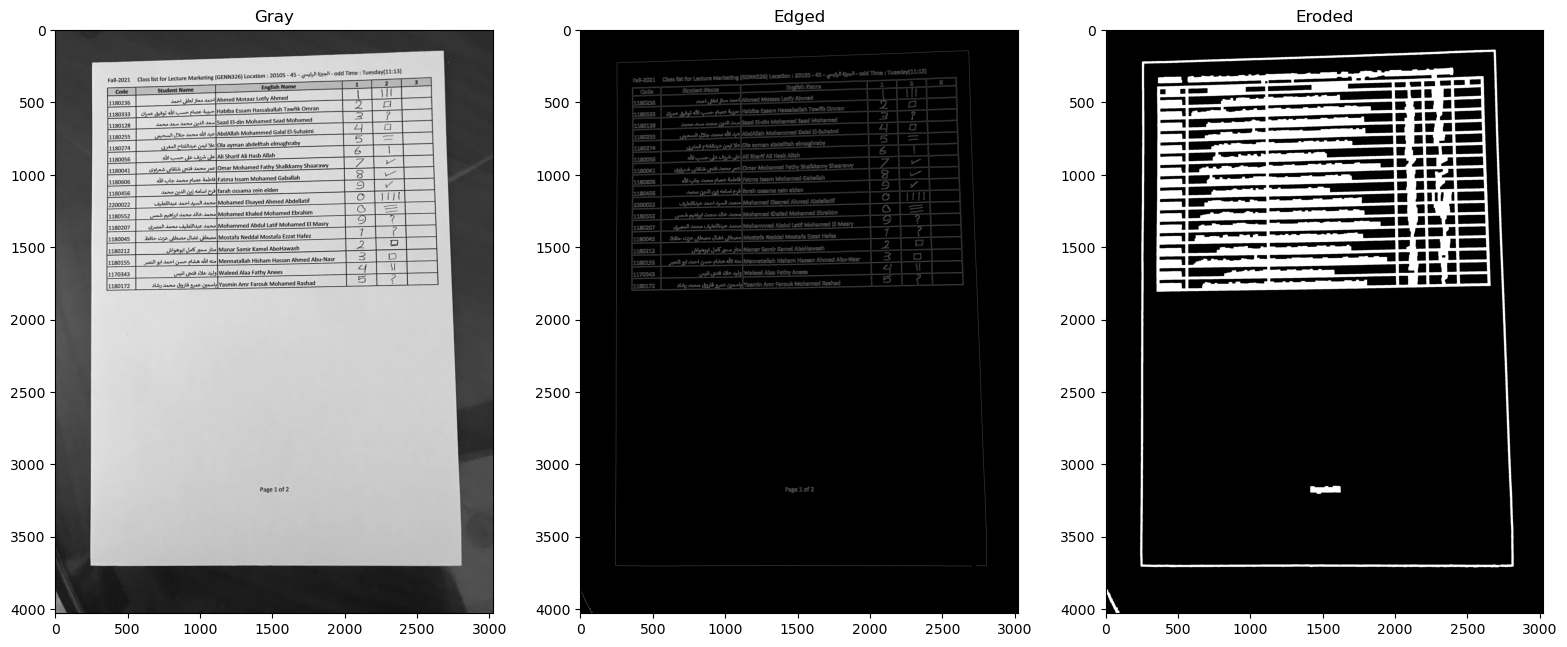

8851490.5
3590.5


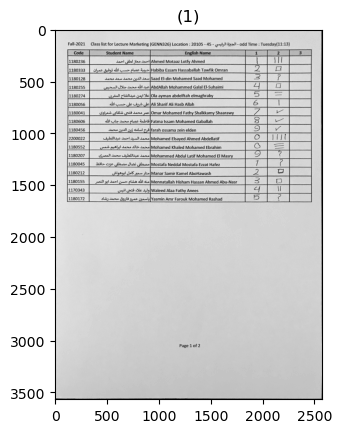

Extracting paper from image 2


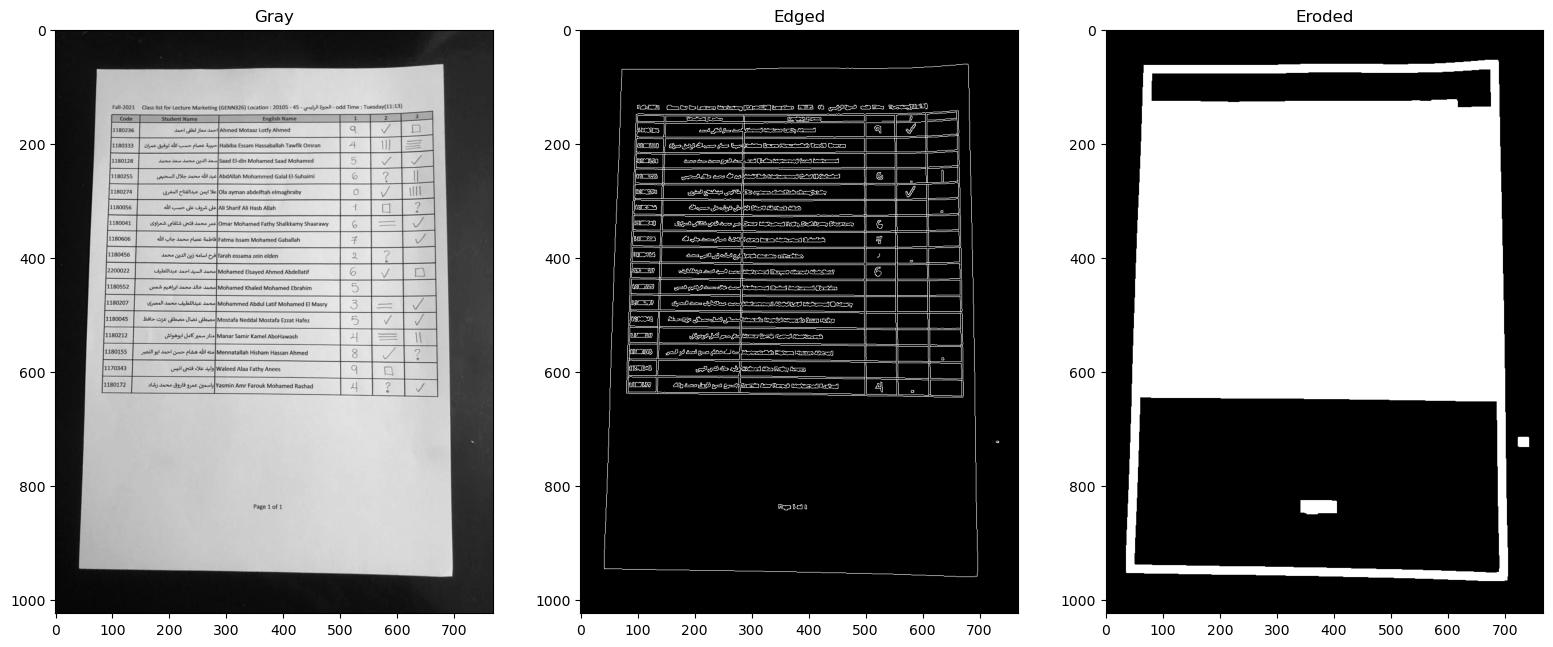

580813.0
320.5


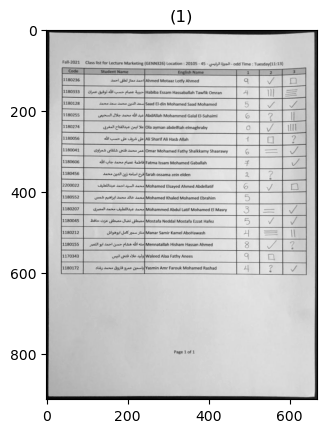

Extracting paper from image 3


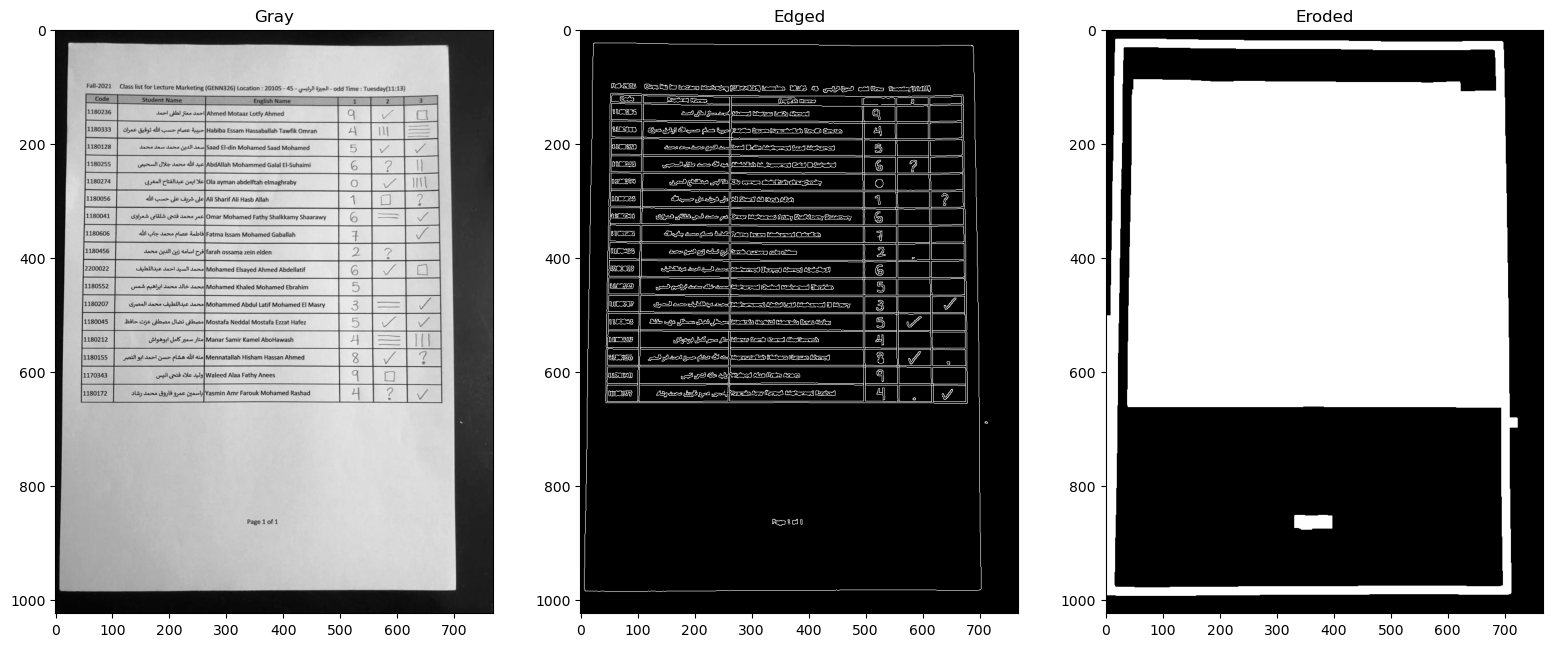

678593.0


IndexError: list index out of range

In [ ]:
import cv2
import numpy as np
from commonfunctions import show_images
def extract_paper(image_path):
    # Step 1: Load the image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    orig = image.copy()
    
    # Step 2: Preprocess the image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    blurred = cv2.GaussianBlur(gray, (7, 7), 1)
    edged = cv2.Canny(blurred, 30, 255)
    
    # we need to apply closing operation to close the gaps between the edges
    kernel = np.ones((15,15),np.uint8)
    dilated_img = cv2.dilate(edged,kernel,iterations=2)
    erroded_img = cv2.erode(dilated_img,kernel,iterations=1)

    show_images([gray, edged,erroded_img], ["Gray", "Edged","Eroded"])

    contrours_img=np.copy(erroded_img)

    # Step 3: Find contours
    contours, _ = cv2.findContours(contrours_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)


    paper_contour = None
    for contour in contours:
        # Approximate the contour
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
        
        # If the contour has four points, we assume it's the paper
        if len(approx) == 4:
            paper_contour = approx
            break

    if paper_contour is None:
        print("Paper contour not found!")
        return None

    # Step 4: Apply a perspective transformation
    def order_points(pts):
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        diff = np.diff(pts, axis=1)
        
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        
        return rect

    

    paper_contour = paper_contour.reshape(4, 2)
    rect = order_points(paper_contour)
    (tl, tr, br, bl) = rect
    
    # Calculate the width and height of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # Perspective transformation
    dst = np.array([
        [0, 0],
        [maxWidth, 0],
        [maxWidth, maxHeight],
        [0, maxHeight]
    ], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(gray, M, (maxWidth, maxHeight))
    
    return warped


for i in range(15): 
    print(f"Extracting paper from image {i+1}")
    img = extract_paper(f"../../Dataset/Grade Sheet/{i+1}.jpg")
    show_images([img])
